# Ay 122b: DSA Interferometry Lab

We begin by checking if the source is point-like. Below, we see a plot of visibility amplitude against baseline length (note that we exclude a baseline length of zero which corresponds to autocorrelation). The roughly flat visibility amplitudes as a function of baseline length suggest the source is indeed point-like.

We also observe that the mystery source traces a similar distribution which likely implies it is also point-like and thus unresolved by the array. The mystery source is later discovered to be QSO 3C 273, and the lower visibility amplitudes are likely the result of snow of the dishes (random guess)! We discuss this further at the end of the notebook.

In [1]:
import numpy as np, matplotlib.pyplot as plt
from astropy import units as u, constants as c
from astropy.coordinates import SkyCoord, AltAz, concatenate, EarthLocation
from astropy.time import Time
from astropy.table import Table, vstack
import random

plt.rcParams.update({'font.size': 15})
%config InlineBackend.figure_format = 'retina'

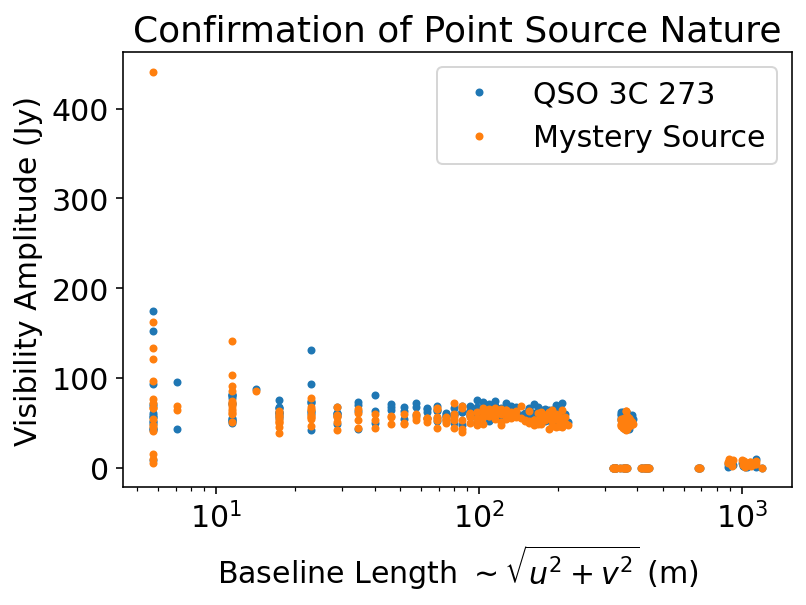

In [2]:
# open data files
data = np.load('data_3C273_fixed.npz')
myst_data = np.load('data_mystery_fixed.npz')
# for i in myst_data.keys():
#     print('Key: ',i)


myst_time = Time(data['times_MJD'], format = 'mjd') 

# baseline = [125, 126, 127, 127]

# plt.plot(myst_data['times_MJD'], myst_data['vis'][:,baseline,0])
# plt.show()

baseline_distance = np.sqrt(data['u_meters'][0,:]**2+data['v_meters'][0,:]**2)
amplitude = np.abs(data['vis'][0,:,0])

baseline_distance_myst = np.sqrt(myst_data['u_meters'][0,:]**2+myst_data['v_meters'][0,:]**2)
amplitude_myst = np.abs(myst_data['vis'][0,:,0])

#[baseline_distance>1e-9]



plt.semilogx(baseline_distance[baseline_distance>1e-9], amplitude[baseline_distance>1e-9], '.', label = 'QSO 3C 273')
plt.semilogx(baseline_distance_myst[baseline_distance>1e-9], amplitude_myst[baseline_distance>1e-9], '.', label = 'Mystery Source')
plt.xlabel('Baseline Length $\\sim \\sqrt{u^2+v^2}$ (m)')
plt.ylabel('Visibility Amplitude (Jy)')
plt.title('Confirmation of Point Source Nature')
plt.legend()
plt.show()

We now solve for the projected baseline lengths of QSO 3C 273. To do so, we assume the source dominates the field of view and thus $$V_{ab}(t) = g_{ab}\int_{\rm FoV} I(\hat{\mathbf{s}}) e^{-i2\pi\mathbf{b_{ab}\cdot\hat{\mathbf{s}}}/\lambda} d\Omega\simeq g_{ab} I_{0} e^{-i2\pi b'_{ab}(t)/\lambda}.$$ The last approximation follows because we've established above that QSO 3C 273 is indeed a point source.

From the provided data file, we know $V_{ab}(t)$, and $\lambda$; from NED, we ascertain the flux density $I_0$, RA, and Dec of QSO 3C 273. Given these quantities, we solve for $g_{ab}$ below.

In [7]:
I_0 = 42*u.Jy # from NED, at 1.41e9 Hz

dec_deg = data['DEC_degrees']*u.deg
nu = data['frequencies_Hz']*u.Hz

# calculate s

ovro = EarthLocation(lat=37.2317*u.deg,lon=-118.2951*u.deg)
time = Time(data['times_MJD'], format = 'mjd') 
aa = AltAz(obstime = time, location=ovro)

qso = SkyCoord(ra = 187.277915*u.deg, dec = 2.052388*u.deg)

qso_aa = qso.transform_to(aa)

s = [qso_aa.az, qso_aa.alt]
# print(s)

s_proj = [np.cos(s[1])*np.sin(s[0]), np.cos(s[1])*np.cos(s[0]), np.sin(s[1])] # astropy quantity is evaluated in radians 

# print(s_proj)

s_unit_proj = s_proj #/np.linalg.norm(s_proj)
# print(s_unit_proj)

def g_ab(baseline):

    base = baseline
    # time = 0

    u_m = list(data['u_meters'][:,base]) #ntimes, nbaselines
    v_m = list(data['v_meters'][:,base]) #ntimes, nbaselines

    b = np.array([u_m, v_m, list(np.zeros(len(u_m)))]) #[u,v,w]
    
    b_ab = []

    for t in range(len(b[0])):
        s_dummy = np.array([s_unit_proj[0][t], s_unit_proj[1][t], s_unit_proj[2][t]])
        b_dummy = np.array([b[0][t], b[1][t], b[2][t]])
    #     print(s_dummy, b_dummy)
        b_ab.append((b_dummy.dot(s_dummy)))

    b_ab = b_ab*u.m
   
    V_ab = data['vis'][:,baseline,0]*u.Jy

    g_ab = V_ab/I_0*np.exp(1j*2*np.pi*b_ab*nu/c.c)
    return g_ab.decompose()

baselines = data['u_meters'].shape[1]
# print(baselines)
g_abs = []

for i in range(baselines):
    g_abs.append(g_ab(i).value)
g_abs # [baseline][time], uncomment for long list


[array([203.32661438-3.02237854e-11j, 203.28652954-3.14941453e-11j,
        203.04154968-3.27305457e-11j, 203.22625732-3.40364246e-11j,
        203.53497314-3.53660572e-11j, 203.58895874-3.66530746e-11j,
        203.39408875-3.78951590e-11j, 203.39378357-3.91721377e-11j,
        203.72503662-4.05146769e-11j, 203.67990112-4.17842172e-11j,
        203.59393311-4.30449810e-11j, 203.79891968-4.43675726e-11j,
        203.82131958-4.56521509e-11j, 203.49067688-4.68550996e-11j,
        203.6683197 -4.81748884e-11j, 203.6782074 -4.94561435e-11j,
        203.45672607-5.06791192e-11j, 203.44664001-5.19541193e-11j,
        203.28904724-5.31898352e-11j, 203.60795593-5.45519098e-11j,
        203.66201782-5.58450193e-11j, 203.36828613-5.70407306e-11j,
        203.50775146-5.83572633e-11j, 203.68215942-5.96858960e-11j,
        203.45120239-6.08956517e-11j, 203.39997864-6.21572536e-11j,
        203.34263611-6.34162551e-11j, 202.97637939-6.45764860e-11j,
        203.47012329-6.60108387e-11j, 203.501144

Above, we see an array of $g_{ab}$ values given a baseline and time. We use these below to fit for the mystery source position.

To aid in our fit, we know that the DSA dishes point on the meridian at zero hour angle. This corresponds to an azimuth of 180 degrees. We get lower and upper bounds on the possible RA values by assuming the dish is pointed at 0 and 90 degrees respectively. This range is shown below.

In [8]:
ovro = EarthLocation(lat=37.2317*u.deg,lon=-118.2951*u.deg)
aa_range = AltAz(alt = [0,90]*u.degree, az = 180*u.degree, obstime = time[0], location=ovro)
coord=SkyCoord(aa_range)
print(f'Range of RAs for Az = 180 deg: {coord.icrs.ra.deg}')

Range of RAs for Az = 180 deg: [186.95768785 186.98725886]


For fitting purposes, we expand this range a bit to [180, 190] degrees. 

We now go about fitting for the mystery source. To do this, we assume the flux density $I_0$ of the source remains constant for all baselines. Given two different baselines, we then have the relation:

$$\frac{V_{ab,1}}{g_{ab,1}}e^{i 2\pi b_{ab,1}/\lambda}=I_0=\frac{V_{ab,2}}{g_{ab,2}}e^{i 2\pi b_{ab,2}/\lambda}.$$

Given a baseline $b$, and time $t$, we can compute $\vec{b}$. We then choose a range of RA's which result in a set of $\hat{s}$ unit vectors, and thus $b_{ab}$ values. Proceeding iteratively, we take $|LHS-RHS|$ of the above expression to compute a "difference" measure for each RA. We tabulate these "difference" measures for 100 random pairs of baselines in the cell below.

In [11]:
diff_tab = Table(names=('RA', 'Diff'))


def diff(b1, b2):
    myst_data = np.load('data_mystery_fixed.npz')

    nu = myst_data['frequencies_Hz']*u.Hz
    baseline_1 = b1
    baseline_2 = b2
    t = [0,1]


    V_ab1 = myst_data['vis'][t, baseline_1, 0]
    V_ab2 = myst_data['vis'][t, baseline_2, 0]

    g_ab1 = g_abs[baseline_1][t]
    g_ab2 = g_abs[baseline_2][t]

    # myst_data['u_meters'][t, baseline_1]

    u_m1 = list(myst_data['u_meters'][t,baseline_1]) #ntimes, nbaselines
    v_m1 = list(myst_data['v_meters'][t,baseline_1]) #ntimes, nbaselines

    u_m2 = list(myst_data['u_meters'][t,baseline_2]) #ntimes, nbaselines
    v_m2 = list(myst_data['v_meters'][t,baseline_2]) #ntimes, nbaselines


    b1 = np.array([u_m1, v_m1, list(np.zeros(len(u_m1)))]) #[u,v,w] 
    b2 = np.array([u_m2, v_m2, list(np.zeros(len(u_m2)))]) #[u,v,w] 

    ovro = EarthLocation(lat=37.2317*u.deg,lon=-118.2951*u.deg)
    time = Time(myst_data['times_MJD'], format = 'mjd')
    aa = AltAz(obstime = time, location=ovro)
    
    
    ras = np.linspace(180, 190, 11)*u.deg
#     print(ras)
    # diff_tab = Table(names=('RA', 'Diff'))

    for ra in ras:

        qso = SkyCoord(ra = ra, dec = myst_data['DEC_degrees']*u.deg)

        qso_aa = qso.transform_to(aa)

        s = [qso_aa.az, qso_aa.alt]

        s_proj = [np.cos(s[1])*np.sin(s[0]), np.cos(s[1])*np.cos(s[0]), np.sin(s[1])] #[np.sin(s[0]), np.cos(s[0]), np.sin(s[1])]

        s_unit_proj = s_proj #/np.linalg.norm(s_proj)

    #     print(s_unit_proj)

        b_ab1 = []
        b_ab2 = []

        for t in range(len(b1[0])): # could also use b2[0]
            s_dummy = np.array([s_unit_proj[0][t], s_unit_proj[1][t], s_unit_proj[2][t]])
            b1_dummy = np.array([b1[0][t], b1[1][t], b1[2][t]])
            b2_dummy = np.array([b2[0][t], b2[1][t], b2[2][t]])
        #     print(s_dummy, b_dummy)
            b_ab1.append((b1_dummy.dot(s_dummy)))
            b_ab2.append((b2_dummy.dot(s_dummy)))

        b_ab1 = b_ab1*u.m
        b_ab2 = b_ab2*u.m
    #     print(b_ab1, b_ab2)

        LHS = V_ab1/g_ab1*np.exp(1j*2*np.pi*b_ab1*nu/c.c)

        RHS = V_ab2/g_ab2*np.exp(1j*2*np.pi*b_ab2*nu/c.c)

        diff = LHS-RHS
    #     print(f'RA: {ra:.2f}, Difference: {np.abs(diff[0]):.2f}')
        diff_tab.add_row([ra, np.abs(diff[0])])

b_max = data['u_meters'].shape[1]
print(f'{b_max} Baselines')
baselines = np.arange(0, b_max)        

q = 0

while q < 100: #number of trials
    baseline1 = random.choice(baselines) 
    remaining_baselines = baselines[baselines != baseline1]
    baseline2 = random.choice(remaining_baselines)
    print(f'Trial {q}, Baselines: {baseline1}, {baseline2}')
    diff(baseline1, baseline2)
    q += 1
diff_tab




325 Baselines
Trial 0, Baselines: 142, 44
Trial 1, Baselines: 248, 172
Trial 2, Baselines: 59, 137
Trial 3, Baselines: 264, 246
Trial 4, Baselines: 319, 25
Trial 5, Baselines: 80, 191


/Users/Nik/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in true_divide


Trial 6, Baselines: 248, 169
Trial 7, Baselines: 21, 207
Trial 8, Baselines: 215, 277
Trial 9, Baselines: 72, 147
Trial 10, Baselines: 121, 105
Trial 11, Baselines: 324, 10
Trial 12, Baselines: 35, 165
Trial 13, Baselines: 23, 41
Trial 14, Baselines: 150, 246
Trial 15, Baselines: 321, 307


/Users/Nik/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in true_divide


Trial 16, Baselines: 189, 87
Trial 17, Baselines: 45, 75
Trial 18, Baselines: 153, 30
Trial 19, Baselines: 34, 98
Trial 20, Baselines: 213, 111
Trial 21, Baselines: 143, 80
Trial 22, Baselines: 279, 306
Trial 23, Baselines: 12, 173
Trial 24, Baselines: 137, 28
Trial 25, Baselines: 109, 205
Trial 26, Baselines: 166, 254
Trial 27, Baselines: 51, 181
Trial 28, Baselines: 53, 148
Trial 29, Baselines: 242, 79
Trial 30, Baselines: 227, 216
Trial 31, Baselines: 211, 251
Trial 32, Baselines: 183, 18
Trial 33, Baselines: 221, 58
Trial 34, Baselines: 124, 135
Trial 35, Baselines: 319, 16
Trial 36, Baselines: 230, 279
Trial 37, Baselines: 211, 237
Trial 38, Baselines: 324, 134
Trial 39, Baselines: 289, 225
Trial 40, Baselines: 214, 323
Trial 41, Baselines: 111, 23
Trial 42, Baselines: 124, 259
Trial 43, Baselines: 69, 59
Trial 44, Baselines: 300, 157
Trial 45, Baselines: 288, 316
Trial 46, Baselines: 121, 97
Trial 47, Baselines: 235, 42
Trial 48, Baselines: 124, 290
Trial 49, Baselines: 121, 164


RA,Diff
float64,float64
180.0,37.40311766874148
181.0,78.84565181521712
182.0,21.757510103971576
183.0,80.24289157684946
184.0,26.319560837451725
185.0,76.12342991126218
186.0,42.518669718291015
187.0,65.21612056655411
188.0,59.84591387359054


We now seek the RA corresponding to the minimum difference. Running the above block several times, we find the most probable RA is $\sim 187$ degrees, suggesting that the mystery source is in fact 3C 273!

RA of min diff: 188.0 deg


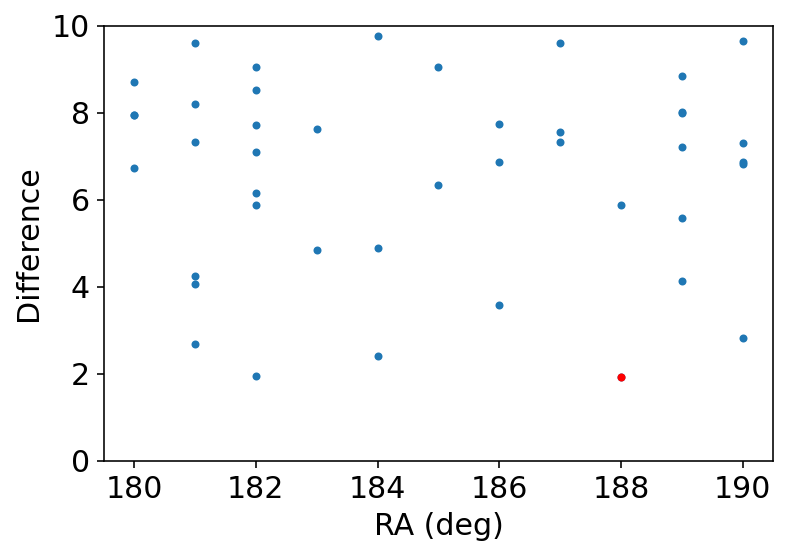

In [12]:
plt.plot(diff_tab['RA'], diff_tab['Diff'], '.')
plt.xlabel('RA (deg)')
plt.ylabel('Difference')
plt.ylim(0,10)

RA_fit = diff_tab[diff_tab['Diff']==np.nanmin(diff_tab['Diff'])]['RA'][0]

print(f"RA of min diff: {RA_fit} deg")

plt.plot(diff_tab[diff_tab['Diff']==np.nanmin(diff_tab['Diff'])]['RA'], diff_tab[diff_tab['Diff']==np.nanmin(diff_tab['Diff'])]['Diff'], 'r.')

plt.show()

For a quick sanity check, we calculate the visibilities for the mystery source given the fitted RA value. We choose an individual baseline and time-stamp below, but the results appear to hold for all of the baselines and times we checked. The results suggest we have a "good" RA fit.

In [14]:
I_0 = 42*u.Jy # from NED, at 1.41e9 Hz

baseline = 137
t = 0

dec_deg = data['DEC_degrees']*u.deg
nu = data['frequencies_Hz']*u.Hz

ovro = EarthLocation(lat=37.2317*u.deg,lon=-118.2951*u.deg)
time = Time(data['times_MJD'][t], format = 'mjd') 
aa = AltAz(obstime = time, location=ovro)

qso = SkyCoord(ra = RA_fit*u.deg, dec = dec_deg)

qso_aa = qso.transform_to(aa)

s = [qso_aa.az, qso_aa.alt]

s_proj = [np.cos(s[1])*np.sin(s[0]), np.cos(s[1])*np.cos(s[0]), np.sin(s[1])] #[np.sin(s[0]), np.cos(s[0]), np.sin(s[1])]

s_unit_proj = s_proj #/np.linalg.norm(s_proj)
# print(s_unit_proj)

u_m = data['u_meters'][t,baseline] #ntimes, nbaselines
v_m = data['v_meters'][t,baseline] #ntimes, nbaselines


b = np.array([u_m, v_m, 0]) #[u,v,w] 
b_ab = (b.dot(s_unit_proj))*u.m

g_ab = g_abs[baseline][t]

V_ab_calc = g_ab*I_0*np.exp(-1j*2*np.pi*b_ab*nu/c.c)


V_ab_data = data['vis'][t,baseline,0]*u.Jy

V_ab_myst_data = myst_data['vis'][t,baseline,0]*u.Jy

print(f"|V_ab(Data)| = {np.abs(V_ab_data):.2f}")
print(f"|V_ab(Mystery Data)| = {np.abs(V_ab_myst_data):.2f}")
print(f"|V_ab(Calculated)| = {np.abs(V_ab_calc):.2f}")
print()

|V_ab(Data)| = 66.42 Jy
|V_ab(Mystery Data)| = 65.65 Jy
|V_ab(Calculated)| = 66.42 Jy



## Questions (and Answers!)

1. As discussed above, the largely flat plot of visibility amplitude vs. baseline length suggests that the mystery source is point-like and unresolved by the array. This follows because $\mathcal{F}\{\delta(t)\}(\omega)=1$. This is confirmed later when we find that the mystery source and QSO 3C 273 are one of the same!
2. We need to have accurate measurements of the $u$ and $v$ coordinates of each antenna which may introduce some uncertainty into our measurements. Obviously, with the proper measuring equipment this can be avoided. We also assume that each antenna is identical and is responding identically. In reality, there may be slight differences in each antenna's response to the same signal. We note that QSO 3C 273 has a jet which may be time variable; this may preclude accurate flux density measurements. We also lack very many "good" (naturally occurring) radio calibrators. Antenna based calibration may allow us to circumvent some of the above issues discussed with baseline-dependent calibrations as all of the baselines are not required.